## Stackoverflow text-classifier

* [Github Repo](https://github.com/GoogleCloudPlatform/ai-platform-text-classifier-shap/blob/master/stackoverflow-classifier.ipynb)

* [Sara's Blog](https://sararobinson.dev/2019/04/23/interpret-bag-of-words-models-shap.html)

* [Youtube Video Tutorial](https://www.youtube.com/watch?v=_RPHiqF2bSs)

In [1]:
!pip freeze | grep tensorflow

tensorflow @ file:///tensorflow-2.5.0-cp37-cp37m-linux_x86_64.whl
tensorflow-datasets==4.0.1
tensorflow-estimator==2.5.0
tensorflow-gcs-config==2.5.0
tensorflow-hub==0.12.0
tensorflow-metadata==1.1.0
tensorflow-probability==0.13.0


In [ ]:
#!pip install tensorflow==1.13.1

In [2]:
import tensorflow as tf 
import pandas as pd
import numpy as np 

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import shuffle

import pickle
import os
import numpy as np

In [3]:
from google.colab import auth
auth.authenticate_user()

In [4]:
!gsutil cp 'gs://cloudml-demo-lcm/SO_ml_tags_avocado_188k_v2.csv' ./

Copying gs://cloudml-demo-lcm/SO_ml_tags_avocado_188k_v2.csv...
- [1 files][276.7 MiB/276.7 MiB]                                                
Operation completed over 1 objects/276.7 MiB.                                    


In [5]:
file = os.path.join('.','SO_ml_tags_avocado_188k_v2.csv')
size = round(os.stat(file).st_size/(1024*1024))
print('File Size is {} MegaBytes '.format(size))

File Size is 277 MegaBytes 


In [6]:
!ls

adc.json  sample_data  SO_ml_tags_avocado_188k_v2.csv


In [7]:
data = pd.read_csv('SO_ml_tags_avocado_188k_v2.csv', names=['tags', 'original_tags', 'text'], header=0)
data = data.dropna()

In [8]:
data = data.drop(columns=['original_tags'])

In [9]:
#get rid of any order inherited from the table
data = shuffle(data, random_state = 22)

In [10]:
data.head()

,tags,text
182914,"tensorflow,keras",avocado image captioning model not compiling b...
48361,pandas,return excel file from avocado with flask in f...
181447,"tensorflow,keras",validating with generator (avocado) i'm trying...
66307,pandas,avocado multiindex dataframe selecting data gi...
11283,pandas,get rightmost non-zero value position for each...


In [ ]:
data.iloc[0].text

'avocado image captioning model not compiling because of concatenate layer when mask_zero=true in a previous layer i am new to avocado and i am trying to implement a model for an image captioning project.   i am trying to reproduce the model from image captioning pre-inject architecture (the picture is taken from this paper: where to put the image in an image captioning generator) (but with a minor difference: generating a word at each time step instead of only generating a single word at the end), in which the inputs for the lstm at the first time step are the embedded cnn features. the lstm should support variable input length and in order to do this i padded all the sequences with zeros so that all of them have maxlen time steps.  the code for the model i have right now is the following:    def get_model(model_name, batch_size, maxlen, voc_size, embed_size,          cnn_feats_size, dropout_rate):      # create input layer for the cnn features     cnn_feats_input = input(shape=(cnn_f

## Feature Engineering

In [11]:
# Encode top tags to multi-hot
tags_split = [tags.split(',') for tags in data['tags'].values]
print(tags_split[0] )

['tensorflow', 'keras']


In [12]:
# One hot encoding
tag_encoder = MultiLabelBinarizer()
tags_encoded = tag_encoder.fit_transform(tags_split)
num_tags = len(tags_encoded[0])
print(tag_encoder.classes_)

['keras' 'matplotlib' 'pandas' 'scikitlearn' 'tensorflow']


In [13]:
#label vector of the first row
tags_encoded[0]

array([1, 0, 0, 0, 1])

## Modeling

In [14]:
# Split our data into train and test sets from the label tags
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

Train size: 150559
Test size: 37640


In [15]:
train_tags = tags_encoded[:train_size]
test_tags = tags_encoded[train_size:]

In [16]:
train_tags

array([[1, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 1],
       ...,
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1]])



### **Creating a class to import in the future**
[Keras preprocessing text method](https://keras.io/preprocessing/text/)

In [17]:
%%writefile preprocess.py

# Pre-processing data: create our tokenizer class
from tensorflow.keras.preprocessing import text

class TextPreprocessor(object):
  def __init__(self, vocab_size):
    self._vocab_size = vocab_size
    self._tokenizer = None
  
  def create_tokenizer(self, text_list):
    """
    This class allows to vectorize a text corpus, by turning each text into either a sequence of 
    integers (each integer being the index of a token in a dictionary) or into a vector where the 
    coefficient for each token could be binary, based on word count, based on tf-idf.
    """
    tokenizer = text.Tokenizer(num_words=self._vocab_size)
    tokenizer.fit_on_texts(text_list)
    self._tokenizer = tokenizer

  def transform_text(self, text_list):
    text_matrix = self._tokenizer.texts_to_matrix(text_list)
    return text_matrix

Writing preprocess.py


In [18]:
# Create vocab from training corpus
from preprocess import TextPreprocessor

VOCAB_SIZE = 400 # This is a hyperparameter -> take the 400 "most important words"

In [19]:
#creating the train/test split
train_qs = data['text'].values[:train_size]
test_qs = data['text'].values[train_size:]

In [21]:
train_qs[0]

'avocado image captioning model not compiling because of concatenate layer when mask_zero=true in a previous layer i am new to avocado and i am trying to implement a model for an image captioning project.   i am trying to reproduce the model from image captioning pre-inject architecture (the picture is taken from this paper: where to put the image in an image captioning generator) (but with a minor difference: generating a word at each time step instead of only generating a single word at the end), in which the inputs for the lstm at the first time step are the embedded cnn features. the lstm should support variable input length and in order to do this i padded all the sequences with zeros so that all of them have maxlen time steps.  the code for the model i have right now is the following:    def get_model(model_name, batch_size, maxlen, voc_size, embed_size,          cnn_feats_size, dropout_rate):      # create input layer for the cnn features     cnn_feats_input = input(shape=(cnn_f

In [22]:
#initializing the class
processor = TextPreprocessor(VOCAB_SIZE)

In [23]:
#creating the matrix with the words size and the corpus of train qs
processor.create_tokenizer(train_qs)

In [24]:
#Creating the bag of words
body_train = processor.transform_text(train_qs)
body_test = processor.transform_text(test_qs)

In [ ]:
#print the size of the matrix & the first vector of the corpus in train
print(len(body_train[0]))
print(body_train[0])

400
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0.
 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0.
 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0.
 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0

In [25]:
# Save the tokenizer!!! 
import pickle

with open('./processor_state.pkl', 'wb') as f:
  pickle.dump(processor, f)

## Build and train our model

In [26]:
# defining the neural net 

def create_model(vocab_size, num_tags):
    
    #Model groups layers into an object with training and inference features.
    model = tf.keras.models.Sequential()
    
    #Input shape = sizeof our matrix vector bag of words
    model.add(tf.keras.layers.Dense(50, input_shape=(VOCAB_SIZE,), activation='relu'))
    #A hidden layer to 25 nodes
    model.add(tf.keras.layers.Dense(25, activation='relu'))
    #Output layer to the number of tags that we want to predict
    model.add(tf.keras.layers.Dense(num_tags, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [27]:
model = create_model(VOCAB_SIZE, num_tags)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                20050     
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 130       
Total params: 21,455
Trainable params: 21,455
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Train

#_train = input bag of words's array -> features
#_tags = labels 
#epochs =  times where the model will iterate through the entire 
#batch size = how many elements the model will look at a time to update weights
#validation split = validation size 

model.fit(body_train, train_tags, epochs=3, batch_size=128, validation_split=0.1)


Epoch 1/3
1059/1059 [==============================] - 4s 3ms/step - loss: 0.1492 - accuracy: 0.8522 - val_loss: 0.1066 - val_accuracy: 0.8936
Epoch 2/3
1059/1059 [==============================] - 3s 2ms/step - loss: 0.1046 - accuracy: 0.8943 - val_loss: 0.1017 - val_accuracy: 0.8947
Epoch 3/3
1059/1059 [==============================] - 3s 3ms/step - loss: 0.0996 - accuracy: 0.8969 - val_loss: 0.0993 - val_accuracy: 0.8989


In [29]:
print('Eval loss/accuracy:{}'.format(model.evaluate(body_test, test_tags, batch_size=128)))

295/295 [==============================] - 0s 1ms/step - loss: 0.1026 - accuracy: 0.8965
Eval loss/accuracy:[0.10263391584157944, 0.896519660949707]


In [30]:
# Export the model to a file
model.save('keras_saved_model.h5')

## Test our model (locally)

1. Instantiate (the saved) model from the file,
2. Instantiate the tokenizer
3. preprocess the text data input text and transform 
4. Predict (the sigmoid probability array)

In [31]:
%%writefile model_prediction.py
import pickle
import os
import numpy as np

class CustomModelPrediction(object):

  def __init__(self, model, processor):
    self._model = model
    self._processor = processor
  
  def predict(self, instances, **kwargs):
    preprocessed_data = self._processor.transform_text(instances)
    predictions = self._model.predict(preprocessed_data)
    return predictions.tolist()

  @classmethod
  def from_path(cls, model_dir):
    import os
    import tensorflow.keras as keras
    model = keras.models.load_model(os.path.join(model_dir,'keras_saved_model.h5'))
    with open(os.path.join(model_dir, 'processor_state.pkl'), 'rb') as f:
      processor = pickle.load(f)

    return cls(model, processor)

Writing model_prediction.py


In [32]:
# Taking two external questions

test_requests = [
  "How to preprocess strings in Keras models Lambda layer? I have the problem that the value passed on to the Lambda layer (at compile time) is a placeholder generated by keras (without values). When the model is compiled, the .eval () method throws the error: You must feed a value for placeholder tensor 'input_1' with dtype string and shape [?, 1] def text_preprocess(x): strings = tf.keras.backend.eval(x) vectors = [] for string in strings: vector = string_to_one_hot(string.decode('utf-8')) vectors.append(vector) vectorTensor = tf.constant(np.array(vectors),dtype=tf.float32) return vectorTensor input_text = Input(shape=(1,), dtype=tf.string) embedding = Lambda(text_preprocess)(input_text) dense = Dense(256, activation='relu')(embedding) outputs = Dense(2, activation='softmax')(dense) model = Model(inputs=[input_text], outputs=outputs) model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) model.summary() model.save('test.h5') If I pass a string array into the input layer statically, I can compile the model, but I get the same error if I want to convert the model to tflite. #I replaced this line: input_text = Input(shape=(1,), dtype=tf.string) #by this lines: test = tf.constant(['Hello', 'World']) input_text = Input(shape=(1,), dtype=tf.string, tensor=test) #but calling this ... converter = TFLiteConverter.from_keras_model_file('string_test.h5') tfmodel = converter.convert() #... still leads to this error: InvalidArgumentError: You must feed a value for placeholder tensor 'input_3' with dtype string and shape [2] [[{{node input_3}}]] ",
  "Change the bar item name in Pandas I have a test excel file like: df = pd.DataFrame({'name':list('abcdefg'), 'age':[10,20,5,23,58,4,6]}) print (df) name  age 0    a   10 1    b   20 2    c    5 3    d   23 4    e   58 5    f    4 6    g    6 I use Pandas and matplotlib to read and plot it: import pandas as pd import numpy as np import matplotlib.pyplot as plt import os excel_file = 'test.xlsx' df = pd.read_excel(excel_file, sheet_name=0) df.plot(kind='bar') plt.show() the result shows: enter image description here it use index number as item name, how can I change it to the name, which stored in column name?"
]

In [33]:
from model_prediction import CustomModelPrediction

classifier = CustomModelPrediction.from_path('.')
model, processor

(<tensorflow.python.keras.engine.sequential.Sequential at 0x7f2ca4140450>,
 <preprocess.TextPreprocessor at 0x7f2cab05f850>)

In [34]:
results = classifier.predict(test_requests)

In [35]:
results[0]

[0.9273104071617126,
 2.0946579297742574e-06,
 0.00045377016067504883,
 0.0005098879337310791,
 0.7578976154327393]

In [37]:
results[1]

[9.475283150095493e-06,
 0.6833502054214478,
 0.729624330997467,
 0.0005828738212585449,
 4.466549398784991e-06]

In [36]:
for i in range(len(results)):
  print('Predicted labels for text-{}:'.format(i))
  for idx, val in enumerate(results[i]):
    if val > 0.7:
      print(tag_encoder.classes_[idx])
  print('\n')

Predicted labels for text-0:
keras
tensorflow


Predicted labels for text-1:
pandas




## Package our model and deploy to AI Platform

## GCP Configuration

In [40]:
!gcloud config set project gap-testing-322018

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud survey



In [53]:
!gcloud config set ai_platform/region global

Updated property [ai_platform/region].


In [41]:
#Copying model and preprocessor to GCS Bucket

!gsutil cp keras_saved_model.h5 gs://tex-classification-stackoverflow
!gsutil cp processor_state.pkl gs://tex-classification-stackoverflow

Copying file://keras_saved_model.h5 [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/282.0 KiB.                                    
Copying file://processor_state.pkl [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/32.0 MiB.                                     


### Source Distribution (or “sdist”)
A distribution format (usually generated using python setup.py sdist) that provides metadata and the essential source files needed for installing by a tool like pip, or for generating a Built Distribution.

In [42]:
%%writefile setup.py

from setuptools import setup

setup(
  name="so_predict",
  version="0.1",
  include_package_data=True,
  scripts=["preprocess.py", "model_prediction.py"]
)

Overwriting setup.py


In [43]:
!python setup.py sdist
!gsutil cp ./dist/so_predict-0.1.tar.gz gs://tex-classification-stackoverflow/packages/so_predict-0.1.tar.gz

running sdist
running egg_info
creating so_predict.egg-info
writing so_predict.egg-info/PKG-INFO
writing dependency_links to so_predict.egg-info/dependency_links.txt
writing top-level names to so_predict.egg-info/top_level.txt
writing manifest file 'so_predict.egg-info/SOURCES.txt'
reading manifest file 'so_predict.egg-info/SOURCES.txt'
writing manifest file 'so_predict.egg-info/SOURCES.txt'

running check


creating so_predict-0.1
creating so_predict-0.1/so_predict.egg-info
copying files to so_predict-0.1...
copying model_prediction.py -> so_predict-0.1
copying preprocess.py -> so_predict-0.1
copying setup.py -> so_predict-0.1
copying so_predict.egg-info/PKG-INFO -> so_predict-0.1/so_predict.egg-info
copying so_predict.egg-info/SOURCES.txt -> so_predict-0.1/so_predict.egg-info
copying so_predict.egg-info/dependency_links.txt -> so_predict-0.1/so_predict.egg-info
copying so_predict.egg-info/top_level.txt -> so_predict-0.1/so_predict.egg-info
Writing so_predict-0.1/setup.cfg
creating di

In [ ]:
# To configure and give access to the API
#!glcloud init

To review details visit https://cloud.google.com/ai-platform/prediction/docs/deploying-models#gcloud

https://cloud.google.com/ai-platform/prediction/docs/custom-prediction-routines

In [52]:
!gcloud ai-platform models create stackoverflow_pred

Please specify a region:
(For the global endpoint the region needs to be specified as 
'global'.)
 [1] global
 [2] asia-east1
 [3] asia-northeast1
 [4] asia-southeast1
 [5] australia-southeast1
 [6] europe-west1
 [7] europe-west2
 [8] europe-west3
 [9] europe-west4
 [10] northamerica-northeast1
 [11] us-central1
 [12] us-east1
 [13] us-east4
 [14] us-west1
 [15] cancel
Please enter your numeric choice:  1

To make this the default region, run `gcloud config set ai_platform/region global`.


Learn more about regional endpoints and see a list of available regions: https://cloud.google.com/ai-platform/prediction/docs/regional-endpoints
Using endpoint [https://ml.googleapis.com/]
Created ai platform model [projects/gap-testing-322018/models/stackoverflow_pred].


In [59]:
!pip freeze | grep tensorflow

tensorflow @ file:///tensorflow-2.5.0-cp37-cp37m-linux_x86_64.whl
tensorflow-datasets==4.0.1
tensorflow-estimator==2.5.0
tensorflow-gcs-config==2.5.0
tensorflow-hub==0.12.0
tensorflow-metadata==1.1.0
tensorflow-probability==0.13.0


https://cloud.google.com/ai-platform/prediction/docs/runtime-version-list

In [61]:
!gcloud beta ai-platform versions create v1 \
--model stackoverflow_pred \
--python-version 3.7 \
--runtime-version 2.5 \
--origin gs://tex-classification-stackoverflow/ \
--package-uris gs://tex-classification-stackoverflow/packages/so_predict-0.1.tar.gz \
--prediction-class model_prediction.CustomModelPrediction \

Using endpoint [https://ml.googleapis.com/]


# Generating predictions in our deployed trained model

In [ ]:
# https://stackoverflow.com/questions/55517871/how-to-preprocess-strings-in-keras-models-lambda-layer
# https://stackoverflow.com/questions/55508547/plot-histogram-for-feature-of-array-with-known-and-limited-values

In [62]:
%%writefile predictions.txt
"How to preprocess strings in Keras models Lambda layer? I have the problem that the value passed on to the Lambda layer (at compile time) is a placeholder generated by keras (without values). When the model is compiled, the .eval () method throws the error"
"I have a test excel file like:df = pd.DataFrame({'name':list('abcdefg'), 'age':[10,20,5,23,58,4,6]})print (df)name  age0    a   101    b   202    c    53    d   234    e   585    f    46    g    6I use Pandas and matplotlib to read and plot it:import pandas as pdimport numpy as npimport matplotlib.pyplot as pltimport osexcel_file = 'test.xlsx'df = pd.read_excel(excel_file, sheet_name=0)df.plot(kind='bar')plt.show()the result shows: enter image description hereit use index number as item name, how can I change it to the name, which stored in column name?"

Writing predictions.txt


In [63]:
# Getting predictions for our model
predictions = !gcloud ai-platform predict --model=stackoverflow_pred --version=v1 --text-instances=predictions.txt 

In [67]:
predictions

['Using endpoint [https://ml.googleapis.com/]',
 '[[0.5487498044967651, 0.0005612969398498535, 0.01081991195678711, 0.009595274925231934, 0.7237932085990906], [1.426701510354178e-05, 0.6793701648712158, 0.7626110911369324, 0.0008813142776489258, 5.05873958900338e-06]]']

In [68]:
for sigmoid_arr in eval(predictions[1]):
  print(sigmoid_arr)
  for idx,probability in enumerate(sigmoid_arr):
    if probability > 0.7:
      print(tag_encoder.classes_[idx])
  print('\n')

[0.5487498044967651, 0.0005612969398498535, 0.01081991195678711, 0.009595274925231934, 0.7237932085990906]
tensorflow


[1.426701510354178e-05, 0.6793701648712158, 0.7626110911369324, 0.0008813142776489258, 5.05873958900338e-06]
pandas




In [69]:
print(tag_encoder.classes_, '\n')

for sigmoid_arr in eval(predictions[1]):
  print(sigmoid_arr)
  for idx,probability in enumerate(sigmoid_arr):
    if probability > 0.7:
      print(tag_encoder.classes_[idx])
  print('\n')

['keras' 'matplotlib' 'pandas' 'scikitlearn' 'tensorflow'] 

[0.5487498044967651, 0.0005612969398498535, 0.01081991195678711, 0.009595274925231934, 0.7237932085990906]
tensorflow


[1.426701510354178e-05, 0.6793701648712158, 0.7626110911369324, 0.0008813142776489258, 5.05873958900338e-06]
pandas




# Interpreting our model with SHAP

In [72]:
!pip install shap
!pip install colored

     |████████████████████████████████| 56 kB 2.2 MB/s 
  Created wheel for colored: filename=colored-1.4.2-py3-none-any.whl size=14021 sha256=bd06a5f05cf2804d66a2d696d0b84ec591b5be9a607a376a3075c70d0ae803d7
  Stored in directory: /root/.cache/pip/wheels/5f/e1/fb/d0e85a8383ff58962319bb81c46e398fa1f4bb9e1feb0f81c4
Successfully built colored


In [74]:
import shap
attrib_data = body_train[:200] ## subset of training data
explainer = shap.DeepExplainer(model, attrib_data)

num_explanations = 25 # subset of test data
shap_vals = explainer.shap_values(body_test[:num_explanations])

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [75]:
body_test[:25]

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 1.],
       [0., 1., 1., ..., 1., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [76]:
words = processor._tokenizer.word_index
dict(list(words.items())[0:10])

{'0': 1,
 '1': 5,
 '2': 9,
 'a': 7,
 'and': 10,
 'avocado': 3,
 'i': 4,
 'in': 8,
 'the': 2,
 'to': 6}

In [77]:
word_lookup = list()
for i in words.keys():
  word_lookup.append(i)

word_lookup = [''] + word_lookup
print(word_lookup[:100])

['', '0', 'the', 'avocado', 'i', '1', 'to', 'a', 'in', '2', 'and', 'is', 'of', 'for', '3', 'x', 'data', 'this', 'with', 'df', 'as', '5', 'it', 'import', '4', 'from', 'gt', 'y', 'that', 'have', 'model', 'dataframe', 'file', 'self', 'but', '00', "'", 'my', 'on', 'np', '10', 'train', 'how', 'python', 'if', 'not', 'get', '7', 'line', '6', '01', 'be', 'like', 'lt', 'using', 'c', 'nan', 'am', 'column', 'py', 'name', 'code', 'input', 'index', 'values', 'can', 'size', 'do', 'plot', 'print', 'columns', 'b', 'so', 'value', 'lib', 'shape', 'set', '8', 'test', 'want', 'error', 'are', 'output', 'an', 'true', 'packages', '12', 'use', 'time', 'n', 'batch', 'return', 'or', 'add', 'by', 'def', 'would', 'list', 'when', '9']


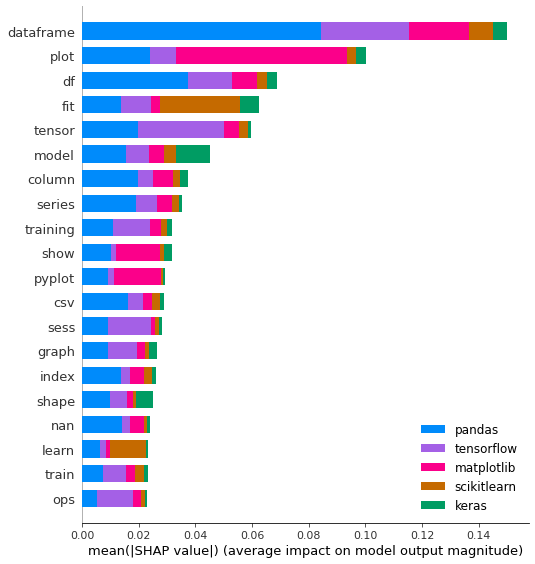

In [78]:
shap.summary_plot(shap_vals, feature_names=word_lookup, class_names=tag_encoder.classes_)

In [79]:
import colored
import re 
def colorprint(question, pos, neg):
  # Split question string on multiple chars
  q_arr = []
  q_filtered = filter(None,re.split("[, .()]+", question))
  for i in q_filtered:
    q_arr.append(i)

  color_str = []
  for idx,word in enumerate(q_arr):
    if word in pos:
      color_str.append(colored.fg("blue") + word)
    elif word in neg:
      color_str.append(colored.fg("light_red") + word)
    else:
      color_str.append(colored.fg('black') + word)

    # For wrapped printing
    if idx % 15 == 0 and idx > 0:
      color_str.append('\n')

  print(' '.join(color_str) + colored.fg('black') + " ")

In [80]:
# Print highlighted signal words for a few questions
examples_to_print = [0,7,20,22,24]

for i in range(len(examples_to_print)):
  
  # Print the actual labels
  actual = test_tags[examples_to_print[i]]
  num_labels = np.sum(actual)

  actual_labels = np.argpartition(actual, -num_labels)[-num_labels:]
  
  # Print the predicted labels
  print('Predicted labels:')
  pred_tag = model.predict([[body_test[examples_to_print[i]]]])
  for idx,tagprob in enumerate(pred_tag[0]):
    if tagprob > 0.8:
      print(tag_encoder.classes_[idx])
  print('\n')

  # Get the highest and lowest signaling words
  for idx,tag in enumerate(pred_tag[0]):
    if tag > 0.7:
      attributions = shap_vals[idx][examples_to_print[i]]
      top_signal_words = np.argpartition(attributions, -5)[-5:]
      pos_words = []
      for word_idx in top_signal_words:
        signal_wd = word_lookup[word_idx]
        pos_words.append(signal_wd)

      negative_signal_words = np.argpartition(attributions, 5)[:5]
      neg_words = []
      for word_idx in negative_signal_words:
        signal_wd = word_lookup[word_idx]
        neg_words.append(signal_wd)
      colorprint(test_qs[examples_to_print[i]],pos_words, neg_words)
  print('\n')

Predicted labels:


ValueError: ignored